# Numerical Analysis of the UE and MIT GSU
This notebook contains a series of analyses on practical implementation details associated with MIT graduate students joining the UE. The purpose of this document is not to argue for or against such an action but rather to concisely answer numerical questions  which were not easily verifiable previously. This notebook was written by one of the authors ([Rohan Kadambi](mailto:kadambi@mit.edu)) of https://uenotformit.org and is hosted on a GitHub repo as a part of that organization's [GitHub](https://github.com/UENotForMIT). 

Most of the data on UE used in this report come from the US Department of Labor Office of Labor-Management Standards Reporting which can be found here:
https://olmsapps.dol.gov/olpdr/. The most recently available data from UE are from 2018. Over the last 20 years, every one of the UE reports to the DOL have been "Received After Due Date". The data presented here show a consistent decline in equity for this organization and so, should more recent data become available they will be added to showcase any changes to this trend. Additionally, the [2019 version of the UE national constitution](https://www.uenotformit.org/2019_Constitution.pdf) was used when specific values from it were required.

As with any analysis, certain assumptions must be made throughout this document. Wherever possible, these assumptions are set up parametrically (e.g. `mit_ave_yearly_rate`) so that the analyses can be rerun easily. Some calculations contain more structural assumptions which are described in detail in those sections (e.g. rounding strategies in 1.4).

### Major Changes
Since the initial release of this document I have gained new information which changes the interpretation of the provided data.
- MIT GSU reports an expected "total dues" of $ 1.44\% $
    - This number does not appear in the constitution of the UE. If one assumes a nominal salary of  $ \$40,000 $ /worker/yr and the minimum national dues are sent this $ 1.44\% $ works out to  $ \$15 $ /worker/month
- The entire graduate population will not be allowed to participate in a union because some of them pay tuition. A more reasonable choice in nominal union membership (`mit_grad_pop`) is $ 5000 $, not $ 6900 $.
- As the purpose of this document is no longer to stand alone I have removed the "Major Results" Section and leave the results and discussion to the individual sections.
- I removed the pie charts summarizing the financial data from 2018 since this information is entirely contained in the "last bar" of each bar graph. These pie charts were made before I had exported all the data required to make the bar graphs.

### Critical Parameters
The variables presented in this section are those which I feel are most important to this analysis. In general, any of the variables defined in this notebook could be modified if a more detailed sensitivity analysis was desired.

In [1]:
# This is a nominal population which would participate in the union
mit_grad_pop = 5000 

# This is a nominal yearly salary for Graduate Students Represented
mit_ave_yearly_rate = 40000 

# This string can take on the values "GSU Report" and "UE Min"
#     When the value is "GSU Report" a "total monthly dues" of 1.44% is considered
#         Because the UE national dues are a fixed fraction of our yearly salary
#         this values is then used to back out the value of the dues which stay with the local
#     When the value is "UE Min" is chosen the minimum dues per the UE Consitstituion are used
#         This minimum is $10 per worker per month UE national constitution Article 18, Section C
local_dues_mode = "GSU Report"

# This fraction represents the part of one's salary which must go to local and national union dues
#     This value is included because the GSU reports a "total monthly dues" of 1.44% despite the UE
#         constitution not referncing this value.
#     This value is only used when `local_dues_mode` is set to "GSU Report"
gsu_total_dues_frac = 0.0144

# When true, this flag will save the graphs generated so that they can be used in other locations
save_figs = False

### Other Constants
- The csvs referenced in this section were exported from the OLM website in a format which simplifies their analysis (i.e. they only contain the relevant data on the UE). The exception to this statement is `ue_all_unions_2018_filename` which is included to show all data were considered and is used in the representation calculations.
- The UE national constitution reports a mandatory dues to the national union of 1.65 hours of pay per worker per month ([UE national constitution Article 15, Section A](https://www.uenotformit.org/2019_Constitution.pdf)). In order for the rate to be converted to a concrete value a nominal hours per year must be chosen. Here the typical value of 2000 work hours per week is used in `nominal_yearly_hours`.

In [2]:
ue_national_assets_filename = "../data/assets.csv"
ue_national_liab_filename = "../data/liabilities.csv"
ue_national_receipts_filename = "../data/receipts.csv"
ue_national_disbursements_filename = "../data/disbursements.csv"
ue_all_unions_2018_filename = "../data/lm_data_data_2018.csv"
ue_finance_summary_filename = "../data/summary.csv"

nominal_yearly_hours = 2000
ue_min_for_vote = 100 # [UE national constitution Article 22, Section C]
ue_hq_dues_rate = 1.65 # hours-of-pay per member per month [UE national constitution Article 15, Section A]
mit_ave_hourly_rate = mit_ave_yearly_rate / nominal_yearly_hours # $/hr
ue_hq_dues = mit_ave_hourly_rate * ue_hq_dues_rate # $ per member per month 

if local_dues_mode == "GSU Report":
    ue_local_dues = mit_ave_yearly_rate/12 * gsu_total_dues_frac - ue_hq_dues
elif local_dues_mode == "UE Min":
    ue_local_dues = 10 # $ per member per month 
else:
    raise ValueError("`local_dues_mode` must be 'GSU Report' or 'UE Min'") 

### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
plt.style.use('seaborn')
mpl.rcParams['text.usetex'] = True

## MIT Financial Contribution
This section calculates the direct cost of membership to MIT graduate students. I choose to report these values per year for the entire graduate population (rather than any single individual's contribution) because the MIT graduate population would interact with UE as a collective.

Fraction to National: 0.69
Fraction to Local: 0.31


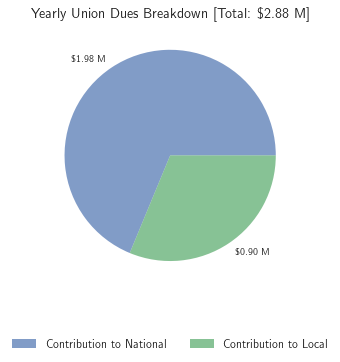

In [4]:
# Do Math
yearly_hq = (ue_hq_dues * mit_grad_pop * 12 / 10**6) 
yearly_local = (ue_local_dues * mit_grad_pop * 12 / 10**6)
yearly_total = yearly_local + yearly_hq
yearly_hq_frac = yearly_hq / yearly_total
yearly_local_frac = yearly_local / yearly_total

# Print Summary
print("Fraction to National: {:.2f}\nFraction to Local: {:.2f}".format(yearly_hq_frac, yearly_local_frac))

# Show Figure
fig, axs = plt.subplots(1, 1, **{'figsize': [6.4, 4.2]});

dues_labels = ['\${:.2f} M'.format(x) for x in [yearly_hq, yearly_local]]

n = axs.pie([yearly_hq, yearly_local], labels=dues_labels);
[n[0][x].set_alpha(0.7) for x in range(len(n))];

axs.set_title("Yearly Union Dues Breakdown [Total: \${:.2f} M]".format(yearly_total),
              fontsize='x-large');

fig.legend(["Contribution to National", "Contribution to Local"],
           loc='upper center', 
           bbox_to_anchor=(0.5, -0.1),
           fancybox=False,
           shadow=False,
           ncol=len(dues_labels),
           fontsize='large')

plt.tight_layout()
      
# Save Figure
if save_figs:
    plt.savefig('./dues_breakdown.svg', bbox_inches='tight')

## UE Financial Status
This section details the changing financial portfolio of UE over the last 20 years. Over this time period we see an 80% reduction in Net Equity while reasonably close to balanced cash flow. This reduction in net equity is not from the depreciation of fixed assets but rather reduced quantity and value of investments per the breakdown of assets presented. These values also provide a scale for the dues calculated in the previous section.

### Update plot colors because this section's graphs have a lot of elements

In [5]:
x = plt.get_cmap("tab20")
z = [x(y) for y in np.linspace(0,1,20)]
old = mpl.rcParams['axes.prop_cycle']
mpl.rcParams['axes.prop_cycle'] = cycler(color=z)

### Load the Data

For the `<type>`s included in {receipt, disbur, asset, liab}, the `<type>_cols` and `<type>_labels_og` create a mapping between the column names in the data from the DOL and their colloquial names.

In [6]:
# Load Receipts
df_receipt = pd.read_csv(ue_national_receipts_filename)
df_receipt.sort_values(by="YR_COVERED", inplace=True);
df_receipt = df_receipt.fillna(0)
receipt_cols = np.array(["DUES", "TAX", "FEES", "SALE", "INTEREST", "DIVIDENDS", "RENTS",
                         "INVESTMENTS", "LOANS_OBTAINED", "LOANS_PAYMENT"])
receipt_labels_og = np.array(["Other Dues", "Dues", "Fees", "Sale of Investment", "Interest",
                           "Dividends", "Rent", "Sale of Investments", "Loans Obtained",
                           "Loans Payed Back"])
df_receipt_cum = df_receipt[np.append(["YR_COVERED"], receipt_cols)]

# Load Disbursements
df_disbur = pd.read_csv(ue_national_disbursements_filename) 
df_disbur.sort_values(by="YR_COVERED", inplace=True);
df_disbur = df_disbur.fillna(0)
disbur_cols = np.array(["REPRESENTATIONAL", "POLITICAL", "CONTRIBUTIONS", "GENERAL_OVERHEAD",
                        "UNION_ADMINISTRATION", "SUPPLIES", "FEES", "DIRECT_TAXES",
                        "STRIKE_BENEFITS", "INVESTMENTS", "BENEFITS", "LOANS_MADE",
                        "LOANS_PAYMENT"])
disbur_labels_og =  np.array(["Representational Activities", "Political Activities/Lobbying",
                           "Contributions/Gifts/Grants", "Overhead", "Union Administration",
                           "Supplies", "Fees", "Taxes", "Strike Benefits", "Invesments Made",
                           "Other Benefits (e.g. Insurance)", "Loans Made", "Loans Repaid"])
df_disbur_cum = df_disbur[np.append(["YR_COVERED"], disbur_cols)]

# Load Assets
df_asset = pd.read_csv(ue_national_assets_filename) 
df_asset.sort_values(by="YR_COVERED", inplace=True);
df_asset = df_asset.fillna(0)
asset_cols = np.array(["CASH_END", "ACCOUNTS_RECEIVABLE_END", "INVESTMENTS_END", "FIXED_ASSETS_END",
                       "TREASURY_SECURITIES_END", "OTHER_ASSETS_END", "LOANS_RECEIVABLE_END"])
asset_labels_og =  np.array(["Cash", "Accounts Recv", "Invesments", "Fixed Assets", "US Treasury Securities",
                          "Other Assets", "Loans Receivable"])
df_asset_cum = df_asset[np.append(["YR_COVERED"], asset_cols)]

# Load Liabilities
df_liab = pd.read_csv(ue_national_liab_filename) 
df_liab.sort_values(by="YR_COVERED", inplace=True);
df_liab = df_liab.fillna(0)
liab_cols = np.array(["OTHER_LIABILITIES_END"])
liab_labels_og =  np.array(["Other Liabilities"])
df_liab_cum = df_liab[np.append(["YR_COVERED"], liab_cols)]

### Plot UE HQ Dues vs Potential MIT Dues to HQ
With the historical data of the UE available, we can compare the hypothetical dues MIT would be required to provide to the UE to the total dues they collected in 2018.

In [7]:
mit_dues = yearly_hq
non_mit_dues = df_receipt[df_receipt["YR_COVERED"]==2018]["TAX"].values[0]/10**6
total_dues = mit_dues + non_mit_dues

Fraction from MIT: 0.31
Fraction from all Others: 0.69


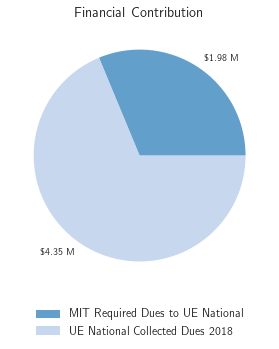

In [8]:
fig, axs = plt.subplots(1, 1, **{'figsize': [6.4, 4.2]});

# Print Summary
print("Fraction from MIT: {:.2f}\nFraction from all Others: {:.2f}".format(mit_dues/total_dues, non_mit_dues/total_dues))

# Plot Financial Contribution Distribution 
dues_labels = ['\${:.2f} M'.format(mit_dues),
               '\${:.2f} M'.format(non_mit_dues)]
n = axs.pie([mit_dues, non_mit_dues], labels=dues_labels);
[n[0][x].set_alpha(0.7) for x in range(len(n))];
axs.set_title("Financial Contribution", fontsize='x-large');

fig.legend(["MIT Required Dues to UE National", "UE National Collected Dues 2018"], loc='upper center', bbox_to_anchor=(0.5, 0),
           fancybox=False, shadow=False, ncol=1, fontsize='large');

plt.tight_layout()

if save_figs:
    plt.savefig('./national_dues.svg')

### Plot Asset Portfolio
Over the last 20 years, the value of the UE assets portfolio has decreased at an average rate of $ \$0.75 $  M/yr

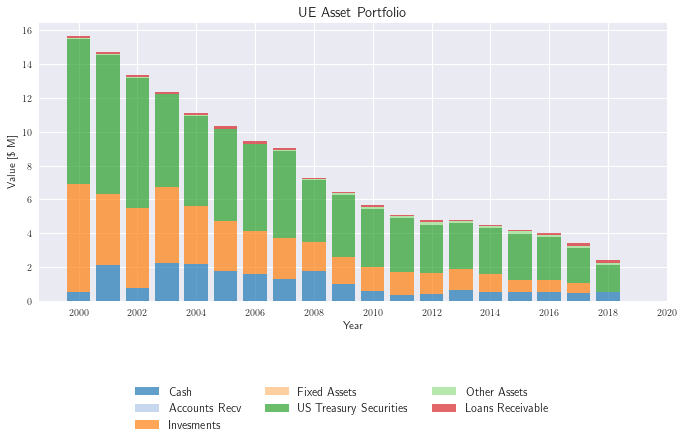

In [9]:
fig, axs = plt.subplots(1, 1, **{'figsize': [9.6, 4.8]});

bottoms = np.zeros_like(df_asset_cum["YR_COVERED"].values, dtype=float)
for col in df_asset_cum.columns[1:]:
    axs.bar(df_asset_cum["YR_COVERED"], df_asset_cum[col].apply(lambda x: x/10**6), bottom=bottoms, alpha=0.7);
    bottoms += df_asset_cum[col].apply(lambda x: x/10**6).values

axs.set_xlabel("Year");
axs.set_ylabel("Value [\$ M]");
axs.set_title("UE Asset Portfolio", fontsize='x-large');
axs.set_xticks(range(2000, 2021, 2));
fig.legend(asset_labels_og, loc='upper center', 
           bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=3, fontsize='large')

plt.tight_layout()
if save_figs:
    plt.savefig('./asset_portfolio.svg', bbox_inches='tight')

### Plot Receipts Portfolio
The receipts portfolio shows the breakdown of money entering the UE on a yearly basis. By reviewing the "receipts" portfolio of the UE one can see that the dips in the asset portfolio are clearly caused by the sale of these investments (rather than a loss of their value). One can also see that over the last 5 years, the amount of money collected in dues has been relatively constant (in 2018 it was $ \$ 4.35 $ M).

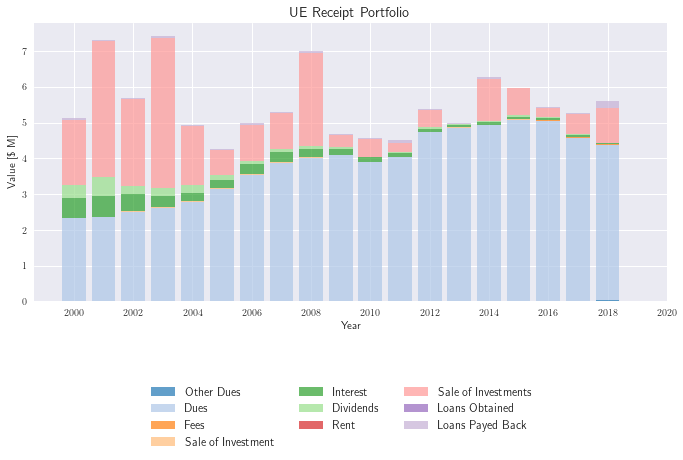

In [10]:
fig, axs = plt.subplots(1, 1, **{'figsize': [9.6, 4.8]});

bottoms = np.zeros_like(df_receipt_cum["YR_COVERED"].values, dtype=float)
for col in df_receipt_cum.columns[1:]:
    axs.bar(df_receipt_cum["YR_COVERED"], df_receipt_cum[col].apply(lambda x: x/10**6), bottom=bottoms, alpha=0.7);
    bottoms += df_receipt_cum[col].apply(lambda x: x/10**6).values

axs.set_xlabel("Year");
axs.set_ylabel("Value [\$ M]");
axs.set_title("UE Receipt Portfolio", fontsize='x-large');
axs.set_xticks(range(2000, 2021, 2));
fig.legend(receipt_labels_og, loc='upper center', 
           bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=3, fontsize='large')

plt.tight_layout()

if save_figs:
    plt.savefig('./receipt_portfolio.svg', bbox_inches='tight')

### Plot Disbursements Portfolio
The disbursements portfolio shows the breakdown in expenditures of the UE on a yearly basis. In general, I think these expenditures are reasonable as the consistently largest contributions are to legal representation and providing worker benefits.

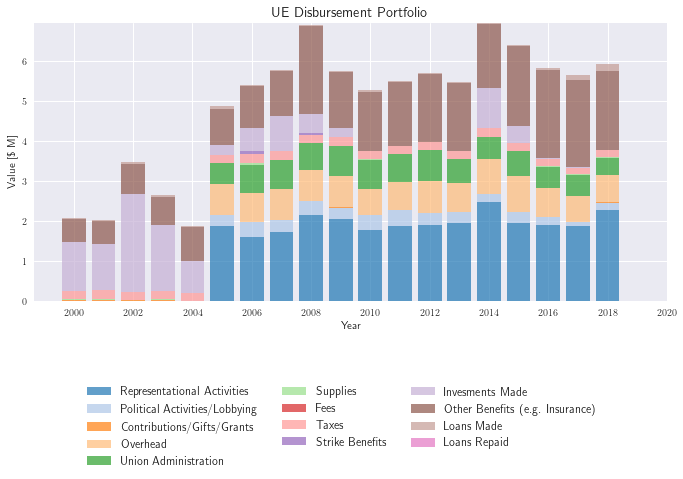

In [11]:
fig, axs = plt.subplots(1, 1, **{'figsize': [9.6, 4.8]});

bottoms = np.zeros_like(df_disbur_cum["YR_COVERED"].values, dtype=float)
for col in df_disbur_cum.columns[1:]:
    axs.bar(df_disbur_cum["YR_COVERED"], df_disbur_cum[col].apply(lambda x: x/10**6), bottom=bottoms, alpha=0.7);
    bottoms += df_disbur_cum[col].apply(lambda x: x/10**6).values

axs.set_xlabel("Year");
axs.set_ylabel("Value [\$ M]");
axs.set_title("UE Disbursement Portfolio", fontsize='x-large');
axs.set_xticks(range(2000, 2021, 2));
fig.legend(disbur_labels_og, loc='upper center', 
           bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=3, fontsize='large')

plt.tight_layout()

if save_figs:
    plt.savefig('./disbursement_portfolio.svg', bbox_inches='tight')

### Plot Cash Flow
Combining the receipts and disbursements plots we can plot the cash flow for each year. Here we can see that the liquidation of assets is associated with covering the UE's "overspending" with respect to the dues they collect.

In [12]:
df_lt = pd.read_csv(ue_finance_summary_filename)
df_lt.sort_values(by="YR_COVERED", inplace=True)
df_lt["CASH_FLOW"] = df_lt.apply(lambda x: (x.TTL_RECEIPTS - x.TTL_DISBURSEMENTS), axis=1)
df_lt["EQUITY"] = df_lt.apply(lambda x: (x.TTL_ASSETS - x.TTL_LIABILITIES), axis=1)

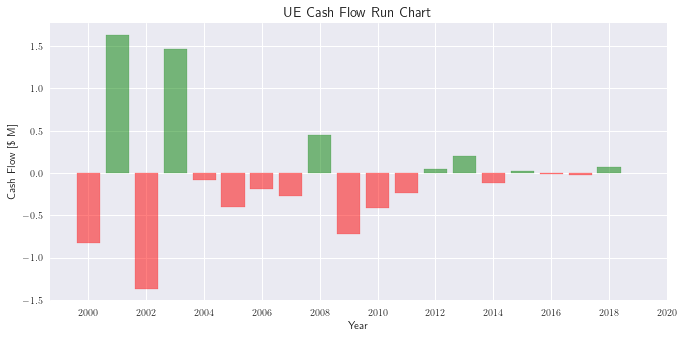

In [13]:
fig, axs = plt.subplots(1, 1, **{'figsize': [9.6, 4.8]})

b = axs.bar(df_lt["YR_COVERED"], df_lt["CASH_FLOW"].apply(lambda x: x/10**6), alpha=0.5);
for x, y in zip(b, df_lt["CASH_FLOW"]):
    if y > 0:
        x.set_color('g')
    else:
        x.set_color('r')
axs.set_xlabel("Year");
axs.set_ylabel("Cash Flow [\$ M]");
axs.set_title("UE Cash Flow Run Chart", fontsize='x-large');
axs.set_xticks(range(2000, 2021, 2));

plt.tight_layout()

if save_figs:
    plt.savefig('./cash_flow.svg', bbox_inches='tight')

### Plot Liability Portfolio
For the sake of completeness we also present the liability portfolio for the UE. In general, the UE does not take out large loans and pays back their loans quickly.

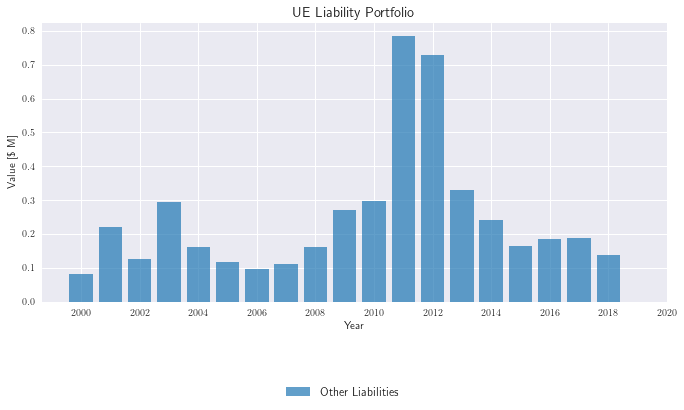

In [14]:
fig, axs = plt.subplots(1, 1, **{'figsize': [9.6, 4.8]});

bottoms = np.zeros_like(df_liab_cum["YR_COVERED"].values, dtype=float)
for col in df_liab_cum.columns[1:]:
    axs.bar(df_liab_cum["YR_COVERED"], df_liab_cum[col].apply(lambda x: x/10**6), bottom=bottoms, alpha=0.7);
    bottoms += df_liab_cum[col].apply(lambda x: x/10**6).values

axs.set_xlabel("Year");
axs.set_ylabel("Value [\$ M]");
axs.set_title("UE Liability Portfolio", fontsize='x-large');
axs.set_xticks(range(2000, 2021, 2));
fig.legend(liab_labels_og, loc='upper center', 
           bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=3, fontsize='large')

plt.tight_layout()

if save_figs:
    plt.savefig('./liabilities_portfolio.svg', bbox_inches='tight')

### Return Plot Color Order

In [15]:
mpl.rcParams['axes.prop_cycle'] = old

## Bounding Analysis of UE Representation
This section considers the distribution of data available for local UE unions and uses them to approximate the voting power MIT would have if they were a part of the UE.

### UE Membership Distribution
This section calculates statistics of the distribution of the size of local UE unions. This quantity is relevant because each local union is given 1 vote per 100 members. This analysis intends to bound the "extent to which MIT's representation would be diminished by" because UE has yet to provide this information to us. Diminished here is represented as % change in democratic representation or:

$$ S = \frac{\left(\text{% of Votes}\right) - \left(\text{% of Membership}\right)}{\left(\text{% of Membership}\right)} $$

This metric goes to 0 when representation is "fair" and goes to -1 (-100%) when MIT would have no voting power. Be aware that the upper bound for this metric is not +1 (+100%) but rather $ \frac{1-\left(\text{% of Membership}\right)}{\left(\text{% of Membership}\right)} $. Since over-representation is unlikely to occur such an unnatural normalization for this cases is deemed acceptable.

### Constants for Analysis

The `lm_data_data_2018.csv` file is a large set containing all records of all unions which filed LM reports with DOL in 2018. This report is included in its entirety as evidence that all data available were considered

In [16]:
col_union_identifier = "AFF_ABBR" # affiliation abbeviation (col to key against 'UE')
col_union_type = "DESIG_NAME" # designation name ('local', 'national', etc.)

### Parse Data

In [17]:
# load data
df_all_unions = pd.read_csv(ue_all_unions_2018_filename, sep='|')

In [18]:
# index out UE unions
df_ue = df_all_unions[df_all_unions[col_union_identifier] == "UE"]

In [19]:
# use startswith to index out union type because of trailing spaces
mask_lambda = lambda df, col, targ: df[col].apply(lambda x: x.startswith(targ))
mask_ue_type = lambda targ: mask_lambda(df_ue, col_union_type, targ)

In [20]:
# decompose captured results
df_ue_local = df_ue[mask_ue_type("LU")]
df_ue_district = df_ue[mask_ue_type("DC")] 
df_ue_regional = df_ue[mask_ue_type("RC")] 
df_ue_national = df_ue[mask_ue_type("NHQ")]

### Dataset Closure
This section compares the data available for UE local (and larger) unions. The analysis clearly shows that the dataset used is incomplete as the cumulative amount of local membership is only ~1/3 of the national membership.

In [21]:
closure_names = ["local", "district", "regional", "national"]

closure_counts = [df_ue_local.shape[0], df_ue_district.shape[0],
                  df_ue_regional.shape[0], df_ue_national.shape[0]]

closure_members = [df_ue_local["MEMBERS"].sum(), df_ue_district["MEMBERS"].sum(),
                   df_ue_regional["MEMBERS"].sum(), df_ue_national["MEMBERS"].sum()]

df_closure = pd.DataFrame({"NAME": closure_names,
                           "NUMBER": closure_counts,
                           "MEMBERS": closure_members})
df_closure.set_index("NAME", inplace=True)

In [22]:
display(df_closure)

,NUMBER,MEMBERS
NAME,,
local,78,11665.0
district,2,8392.0
regional,1,3540.0
national,1,34275.0


### Local Level Size Distribution
This section generates histograms which show the distribution of local union size within the UE. The median union size is 52 members.

In [23]:
local_med = df_ue_local["MEMBERS"].median()
display(local_med)

52.0

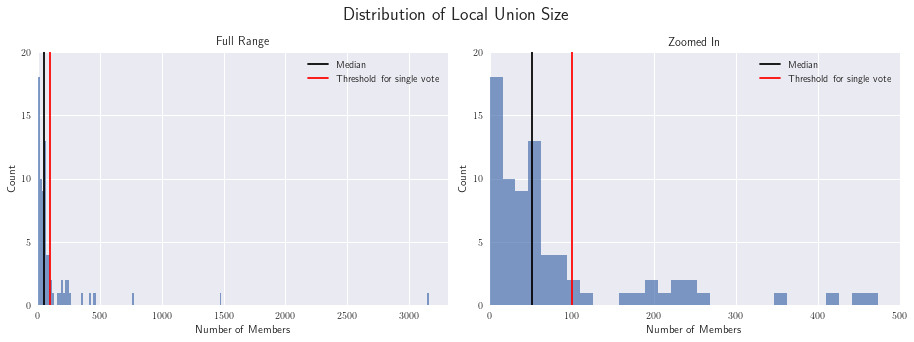

In [24]:
fig, axs = plt.subplots(1, 2, **{'figsize': [12.8, 4.8]});
d = 5

# Full Range
axs[0].hist(df_ue_local["MEMBERS"], 200, alpha=0.7);
axs[0].axvline(local_med, **{'color': 'k'});
axs[0].axvline(ue_min_for_vote, **{'color': 'r'});

axs[0].set_ylim([0, 20]);
axs[0].set_xlim([0, axs[0].get_xlim()[1]])
axs[0].set_yticks(range(0, 20 + d, d));

axs[0].set_title("Full Range");
axs[0].set_xlabel("Number of Members");
axs[0].set_ylabel("Count");
axs[0].legend(["Median", "Threshold for single vote"]);

# Zoom In
axs[1].hist(df_ue_local['MEMBERS'], 200, alpha=0.7);
axs[1].axvline(local_med, **{'color': 'k'})
axs[1].axvline(ue_min_for_vote, **{'color': 'r'})
axs[1].set_ylim([0, 20]);
axs[1].set_xlim([0, 500]);

axs[1].set_yticks(range(0, 20 + d, d));
axs[1].set_title("Zoomed In");
axs[1].set_xlabel("Number of Members");
axs[1].set_ylabel("Count");
axs[1].legend(["Median", "Threshold for single vote"]);

fig.suptitle("Distribution of Local Union Size",
             fontsize = 18);
plt.tight_layout()

### Hypothetically Add MIT to the Data Available
In order to add MIT to the data available we need to reconcile two major questions:

1) To what population are we adding MIT (given that our dataset is clearly incomplete)?
- Given the consistent reports of UE union size and the fact that the sum of all locals matches neither national, regional, or district membership counts. It is clear that there is no value in adding MIT to the distributions of locals reporting directly. We therefore **assume** that this distribution is representative of UE overall and scale the distribution by the relative increase in membership of the national union. Practically this means we'll calculate the total votes available to each local union (see next bullet), aggregate them and then multiply by ratio of national membership to cumulative local membership.

2) How are votes calculated?
- Article 22 Section C of the national constitution states ". The basis of representation shall be one vote for every one hundred members or major fraction thereof."
- Such a definition is ambiguous as to what should be done for local unions whose number of members is less than the minimum threshold for a vote ($ n_{min} =100 $) or at least whose membership is less than a "major fraction thereof" ($ n_{min}/2 =50 $). As I see it there are three reasonable interpretations:
    1) Simple rounding (SIM):  
        In this definition we simply give unions which are "too small" no votes. This seems highly unlikely to be the actual practice but is included as a "lower bound".
        $$ n_\text{votes}\left(n_\text{members}\right) = \left\lfloor\frac{n_\text{members}}{n_{min}}\right\rceil $$
        $$ n_\text{votes}^T = \sum_{\text{locals}} n_\text{votes}\left(n_\text{members}\right) $$
    
    
    2) At least one rounding (ALO):  
       In this definition unions are given 1 vote until they qualify for more by the traditional rounding scheme. Such a definition strongly over-weights small unions making it unlikely in practice but a reasonable "upper bound".

        $$  n_\text{votes}\left(n_\text{members}\right)  \max \left\{1,\left\lfloor\frac{n_\text{members}}{n_{min}}\right\rceil \right\}  $$
        $$ n_\text{votes}^T = \sum_{\text{locals}} n_\text{votes}\left(n_\text{members}\right) $$
    
   
    3) Threshold Aggregation ($ \text{TA}_{t} $)  
        This definition does not have a simple per union definition since it explicitly aggregates them. For this definition of rounding unions which are smaller than some threshold $ t $ are required to aggregate until they surpass the threshold. The obvious choice for such a threshold is $ t = n_{min}/2 $ since major fractions are already considered sufficient for a vote. One can place an upper bound on the total number of votes which would be present in a pool given such a scheme with:
        $$ n_\text{votes}^T = \sum_{\text{locals}|n_\text{members}>t} \left\lfloor\frac{n_\text{members}}{n_{min}}\right\rceil + \frac{1}{t}\sum_{\text{locals}|n_\text{members} < t} n_{\text{members}} $$

        

In [25]:
rounding_sim = lambda x: np.round(x)
rounding_alo = lambda x: np.max(np.array([np.ceil(x), 1]))

t = ue_min_for_vote/2

In [26]:
df_ue_local = df_ue_local.assign(VOTES_SIM=df_ue_local.apply(lambda x: rounding_sim(x.MEMBERS/ue_min_for_vote), axis=1))
df_ue_local = df_ue_local.assign(VOTES_ALO=df_ue_local.apply(lambda x: rounding_alo(x.MEMBERS/ue_min_for_vote), axis=1))

scale = df_closure.loc["national", "MEMBERS"] / df_closure.loc["local", "MEMBERS"]

non_mit_members = df_closure.loc["national", "MEMBERS"]
mit_members = mit_grad_pop
total_members = mit_members + non_mit_members

mit_votes = rounding_sim(mit_grad_pop/ue_min_for_vote)

In [27]:
members_set = df_ue_local["MEMBERS"].values

ta_members = rounding_sim(members_set[members_set >= t]/ue_min_for_vote).sum() + np.round(members_set[members_set < t].sum()/t)

In [28]:
non_mit_votes = {'sim': df_ue_local["VOTES_SIM"].values.sum() * scale,
                 'alo': df_ue_local["VOTES_ALO"].values.sum() * scale,
                 'ta50': ta_members * scale}

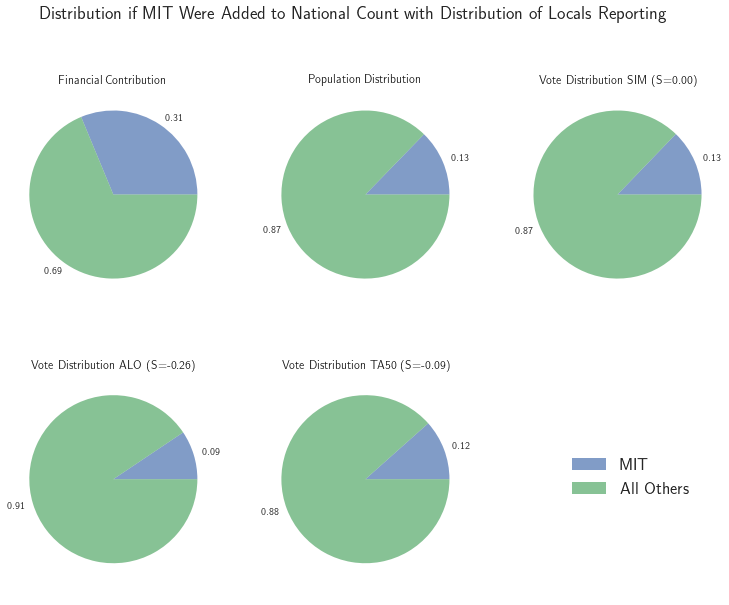

In [29]:
fig, axs = plt.subplots(2, 3, **{'figsize': [6.4*2, 4.8*2]});

axs = axs.flatten()

idx = 0
# Plot Financial Contribution Distribution 
dues_labels = ['{:.2f}'.format(mit_dues/(total_dues)),
               '{:.2f}'.format(non_mit_dues/(total_dues))]
n = axs[idx].pie([mit_dues, non_mit_dues], labels=dues_labels);
[n[0][x].set_alpha(0.7) for x in range(len(n))];
axs[idx].set_title("Financial Contribution", fontsize='large');
idx += 1

# Plot Population Distribution
member_labels = ['{:.2f}'.format(mit_members/(total_members)),
                 '{:.2f}'.format(non_mit_members/(total_members))]
f_pop = mit_members/(total_members)
n = axs[idx].pie([mit_members, non_mit_members], labels=member_labels);
[n[0][x].set_alpha(0.7) for x in range(len(n))];
axs[idx].set_title("Population Distribution", fontsize='large');
idx += 1

for key in non_mit_votes.keys():
    total_votes = mit_votes + non_mit_votes[key]
    vote_labels = ['{:.2f}'.format(mit_votes/(total_votes)),
                   '{:.2f}'.format(non_mit_votes[key]/(total_votes))]
    n = axs[idx].pie([mit_votes,  non_mit_votes[key]], labels=vote_labels);
    [n[0][x].set_alpha(0.7) for x in range(len(n))];
    f_vote = mit_votes/(total_votes)
    S = (f_vote - f_pop)/f_pop
    axs[idx].set_title("Vote Distribution {:} (S={:.2f})".format(key.upper(), S), fontsize='large');
    idx += 1

axs[5].get_xaxis().set_visible(False)
axs[5].get_yaxis().set_visible(False)    
axs[5].set_facecolor("none")
    
fig.suptitle("Distribution if MIT Were Added to National Count with Distribution of Locals Reporting",
             fontsize = 18);
fig.legend(["MIT", "All Others"], loc='upper center', bbox_to_anchor=(3.6/4.5, 2.1/6),
           fancybox=False, shadow=False, ncol=1, fontsize='xx-large');

## Extra Plots
This section simply generates figures containing subsets of the set of pie charts shown above

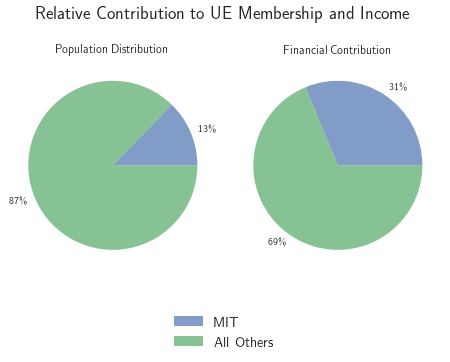

In [30]:
fig, axs = plt.subplots(1, 2, **{'figsize': [6.4, 4.2]});

axs = axs.flatten()

idx = 0
# Plot Population Distribution
member_labels = ['{:.0f}\%'.format(mit_members/(total_members)*100),
                 '{:.0f}\%'.format(non_mit_members/(total_members)*100)]
f_pop = mit_members/(total_members)
n = axs[idx].pie([mit_members, non_mit_members], labels=member_labels);
[n[0][x].set_alpha(0.7) for x in range(len(n))];
axs[idx].set_title("Population Distribution", fontsize='large');
idx += 1

# Plot Financial Contribution Distribution 
dues_labels = ['{:.0f}\%'.format(mit_dues/(total_dues)*100),
               '{:.0f}\%'.format(non_mit_dues/(total_dues)*100)]
n = axs[idx].pie([mit_dues, non_mit_dues], labels=dues_labels);
[n[0][x].set_alpha(0.7) for x in range(len(n))];
axs[idx].set_title("Financial Contribution", fontsize='large');
fig.suptitle("Relative Contribution to UE Membership and Income",
             fontsize = 18);
fig.legend(["MIT", "All Others"], loc='upper center', bbox_to_anchor=(0.5, 0),
           fancybox=False, shadow=False, ncol=1, fontsize='x-large');

plt.tight_layout()

if save_figs:
    plt.savefig('./relative_contribution.svg')

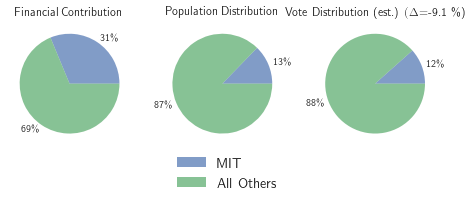

In [31]:
fig, axs = plt.subplots(1, 3, **{'figsize': [6.4, 4.2]});
axs = axs.flatten()

idx = 0
# Plot Financial Contribution Distribution 
dues_labels = ['{:.0f}\%'.format(mit_dues/(total_dues)*100),
               '{:.0f}\%'.format(non_mit_dues/(total_dues)*100)]
n = axs[idx].pie([mit_dues, non_mit_dues], labels=dues_labels);
[n[0][x].set_alpha(0.7) for x in range(len(n))];
axs[idx].set_title("Financial Contribution", fontsize='large');
idx += 1

# Plot Population Distribution
member_labels = ['{:.0f}\%'.format(mit_members/(total_members)*100),
                 '{:.0f}\%'.format(non_mit_members/(total_members)*100)]
f_pop = mit_members/(total_members)
n = axs[idx].pie([mit_members, non_mit_members], labels=member_labels);
[n[0][x].set_alpha(0.7) for x in range(len(n))];
axs[idx].set_title("Population Distribution", fontsize='large');
idx += 1

for key in ["ta50"]:
    total_votes = mit_votes + non_mit_votes[key]
    vote_labels = ['{:.0f}\%'.format(mit_votes/(total_votes)*100),
                   '{:.0f}\%'.format(non_mit_votes[key]/(total_votes)*100)]
    n = axs[idx].pie([mit_votes,  non_mit_votes[key]], labels=vote_labels);
    [n[0][x].set_alpha(0.7) for x in range(len(n))];
    f_vote = mit_votes/(total_votes)
    S = (f_vote - f_pop)/f_pop
    axs[idx].set_title("Vote Distribution (est.) $ (\Delta $={:.1f} \%)".format(S*100), fontsize='large');
    idx += 1

axs[2].get_xaxis().set_visible(False)
axs[2].get_yaxis().set_visible(False)    
axs[2].set_facecolor("none")
    

fig.legend(["MIT", "All Others"], loc='upper center', bbox_to_anchor=(0.5, 0.3),
           fancybox=False, shadow=False, ncol=1, fontsize='x-large');

plt.tight_layout()

if save_figs:
    plt.savefig('./vote.svg', bbox_inches='tight')